### Instalamos el paquete de MLflow

In [1]:
#pip install mlflow

### Importamos las librerias del proyecto

In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import mlflow
import mlflow.sklearn

# Configurar la visualización
sns.set(style="whitegrid")

### Importamos la base de datos de terremotos del USGS:

In [3]:
# Definir la URL de la API
url = "https://earthquake.usgs.gov/fdsnws/event/1/query"

# Parámetros de la solicitud
params = {
    "format": "geojson",
    "starttime": "2010-01-01",
    "endtime": "2020-01-01",
    "minmagnitude": 4.0,
    "limit": 10000  # Limitar el número de resultados
}

# Hacer la solicitud GET
response = requests.get(url, params=params)

# Convertir la respuesta a JSON
data = response.json()

# Convertir a DataFrame de pandas
earthquakes = pd.json_normalize(data["features"])

### Visualizamos la base de datos:

In [4]:
# Mostrar las primeras filas del DataFrame
print(earthquakes.head())

      type            id  properties.mag  \
0  Feature    us7000709t             4.3   
1  Feature    us70006t0z             4.0   
2  Feature  pr2019365044             4.2   
3  Feature    us70006sxv             4.6   
4  Feature    us70006sxu             4.8   

                        properties.place  properties.time  properties.updated  \
0         115 km SSW of Isangel, Vanuatu    1577836619933       1584224567040   
1     5 km E of Desamparados, Costa Rica    1577833784616       1584224567040   
2  8 km SE of Maria Antonia, Puerto Rico    1577833662730       1584224567040   
3                                 Taiwan    1577819410306       1584224569040   
4          225 km SE of Kuril’sk, Russia    1577818975645       1584224569040   

   properties.tz                                     properties.url  \
0            NaN  https://earthquake.usgs.gov/earthquakes/eventp...   
1            NaN  https://earthquake.usgs.gov/earthquakes/eventp...   
2            NaN  https://earthquak

### Verificamos el tipo de dato del Dataframe:

In [5]:
# verificamos el tipo de dato del Dataframe
print(type(earthquakes))

<class 'pandas.core.frame.DataFrame'>


### Preprocesamiento de Datos

### Limpieza de Datos:

In [6]:
# Seleccionar las columnas relevantes
earthquakes = earthquakes[["properties.mag", "properties.place", "properties.time", 
                           "geometry.coordinates"]]

# Renombrar las columnas
earthquakes.columns = ["magnitud", "lugar", "tiempo", "coordenadas"]

# Extraer las coordenadas en latitud y longitud
coordenadas = earthquakes["coordenadas"].tolist()
longitud = [coord[0] for coord in coordenadas]
latitud = [coord[1] for coord in coordenadas]
earthquakes["longitud"] = longitud
earthquakes["latitud"] = latitud
earthquakes = earthquakes.drop(columns=["coordenadas"])

# Convertir el tiempo a un formato legible
earthquakes["tiempo"] = pd.to_datetime(earthquakes["tiempo"], unit='ms')

# Crear características adicionales como el mes, el día y la hora del día
earthquakes["mes"] = earthquakes["tiempo"].dt.month
earthquakes["día"] = earthquakes["tiempo"].dt.day
earthquakes["hora"] = earthquakes["tiempo"].dt.hour

# Crear una variable objetivo (p. ej., si la magnitud es >= 5)
earthquakes["target"] = (earthquakes["magnitud"] >= 5).astype(int)

### Visualizamos la base de datos nuevamente:

In [19]:
# Mostrar las primeras filas del DataFrame
print(earthquakes)

      magnitud                                  lugar                  tiempo  \
0          4.3         115 km SSW of Isangel, Vanuatu 2019-12-31 23:56:59.933   
1          4.0     5 km E of Desamparados, Costa Rica 2019-12-31 23:09:44.616   
2          4.2  8 km SE of Maria Antonia, Puerto Rico 2019-12-31 23:07:42.730   
3          4.6                                 Taiwan 2019-12-31 19:10:10.306   
4          4.8          225 km SE of Kuril’sk, Russia 2019-12-31 19:02:55.645   
...        ...                                    ...                     ...   
9995       4.5                            Fiji region 2019-04-05 00:04:39.928   
9996       4.4     56 km SSE of Champerico, Guatemala 2019-04-04 22:56:14.520   
9997       4.6                117 km S of Naze, Japan 2019-04-04 22:11:27.283   
9998       5.1          Volcano Islands, Japan region 2019-04-04 21:34:38.880   
9999       4.1      156 km SE of Gorontalo, Indonesia 2019-04-04 18:53:49.268   

      longitud  latitud  me

In [18]:
earthquakes.describe()

,magnitud,longitud,latitud,mes,día,hora,target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,4.54367,35.678934,2.744273,8.097700,16.19600,11.533400,0.121300
std,0.39553,123.506216,27.793215,2.590024,8.58439,6.919557,0.326492
min,4.00000,-179.979900,-65.607100,4.000000,1.00000,0.000000,0.000000
25%,4.30000,-73.102775,-18.180350,6.000000,9.00000,5.000000,0.000000
50%,4.50000,99.841900,-0.479250,8.000000,16.00000,12.000000,0.000000
75%,4.70000,138.365975,24.478375,10.000000,24.00000,17.000000,0.000000
max,8.00000,179.997900,85.781500,12.000000,31.00000,23.000000,1.000000


In [8]:
print(type(earthquakes["magnitud"]))

<class 'pandas.core.series.Series'>


### Revisamos la distribución de los datos:

In [9]:
# Verificar la distribución de la variable objetivo
print(earthquakes["target"].value_counts())

0    8787
1    1213
Name: target, dtype: int64


### EDA del Dataframe:

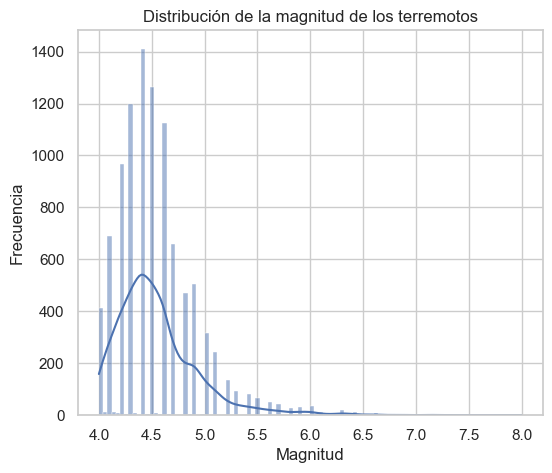

C:\Users\fgf_7\AppData\Local\Temp\ipykernel_9364\1924238690.py:11: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(earthquakes.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)


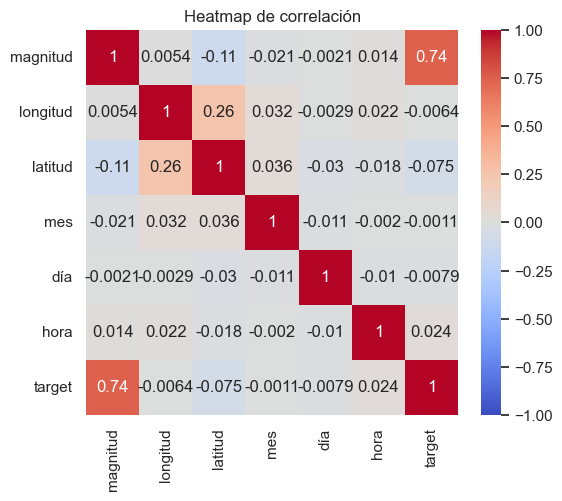

In [10]:
# Histogramas de magnitud
plt.figure(figsize=(6, 5))
sns.histplot(earthquakes["magnitud"], bins=100, kde=True)
plt.title("Distribución de la magnitud de los terremotos")
plt.xlabel("Magnitud")
plt.ylabel("Frecuencia")
plt.show()

# Mapa de calor de correlación
plt.figure(figsize=(6, 5))
sns.heatmap(earthquakes.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Heatmap de correlación")
plt.show()

### Entrenamiento del modelo:

### Dividimos el DataFrame en sets de entrenamiento y prueba:

In [11]:
# Seleccionar las características y la variable objetivo
features = earthquakes[["longitud", "latitud", "mes", "día", "hora"]]
target = earthquakes["target"]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=42, stratify=target)

# Verificar el balance de clases en el conjunto de entrenamiento y prueba
print("Distribución en el conjunto de entrenamiento:")
print(y_train.value_counts())
print("\nDistribución en el conjunto de prueba:")
print(y_test.value_counts())

Distribución en el conjunto de entrenamiento:
0    7908
1    1092
Name: target, dtype: int64

Distribución en el conjunto de prueba:
0    879
1    121
Name: target, dtype: int64


### Configuramos MLflow para realizar los experimentos:

In [20]:
# Configurar nombre del experimento en MLflow
mlflow.set_experiment("Earthquake Classification 2")

# Definimos combinaciones de hiperparámetros a probar
param_grid = {
    "n_estimators": [50, 100, 150, 200],
    "max_depth": [10, 15, 20, None],
    "min_samples_split": [2, 5, 10]
}

# Probar diferentes combinaciones de hiperparámetros
for n_estimators in param_grid["n_estimators"]:
    for max_depth in param_grid["max_depth"]:
        for min_samples_split in param_grid["min_samples_split"]:
            with mlflow.start_run():
                # Entrenar un modelo de Random Forest con los hiperparámetros actuales
                model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
                model.fit(X_train, y_train)

                # Hacer predicciones en el conjunto de prueba
                y_pred = model.predict(X_test)

                # Registrar el modelo
                mlflow.sklearn.log_model(model, "random_forest_model")

                # Registrar parámetros
                mlflow.log_param("n_estimators", n_estimators)
                mlflow.log_param("max_depth", max_depth)
                mlflow.log_param("min_samples_split", min_samples_split)

                # Calcular y registrar métricas
                accuracy = accuracy_score(y_test, y_pred)
                precision = precision_score(y_test, y_pred)
                recall = recall_score(y_test, y_pred)
                f1 = f1_score(y_test, y_pred)

                mlflow.log_metric("accuracy", accuracy)
                mlflow.log_metric("precision", precision)
                mlflow.log_metric("recall", recall)
                mlflow.log_metric("f1_score", f1)

                # Imprimir el reporte de clasificación
                print(f"n_estimators: {n_estimators}, max_depth: {max_depth}, min_samples_split: {min_samples_split}")
                print(classification_report(y_test, y_pred))         

Traceback (most recent call last):
  File "D:\A\Anaconda3\Lib\site-packages\mlflow\store\tracking\file_store.py", line 302, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\A\Anaconda3\Lib\site-packages\mlflow\store\tracking\file_store.py", line 395, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\A\Anaconda3\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1320, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\A\Anaconda3\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1313, in _read_helper
    result = read_yaml(root, file_name)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\A\Anaconda3\Lib\site-packages\mlflow\utils\file_u

n_estimators: 50, max_depth: 10, min_samples_split: 2
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       879
           1       0.50      0.01      0.02       121

    accuracy                           0.88      1000
   macro avg       0.69      0.50      0.48      1000
weighted avg       0.83      0.88      0.82      1000

n_estimators: 50, max_depth: 10, min_samples_split: 5
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       879
           1       1.00      0.01      0.02       121

    accuracy                           0.88      1000
   macro avg       0.94      0.50      0.48      1000
weighted avg       0.89      0.88      0.82      1000

n_estimators: 50, max_depth: 10, min_samples_split: 10
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       879
           1       1.00      0.01      0.02       121

    accuracy       

n_estimators: 100, max_depth: None, min_samples_split: 5
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       879
           1       0.56      0.08      0.14       121

    accuracy                           0.88      1000
   macro avg       0.72      0.54      0.54      1000
weighted avg       0.85      0.88      0.84      1000

n_estimators: 100, max_depth: None, min_samples_split: 10
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       879
           1       0.60      0.05      0.09       121

    accuracy                           0.88      1000
   macro avg       0.74      0.52      0.51      1000
weighted avg       0.85      0.88      0.83      1000

n_estimators: 150, max_depth: 10, min_samples_split: 2
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       879
           1       1.00      0.01      0.02       121

    accuracy

n_estimators: 200, max_depth: 20, min_samples_split: 10
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       879
           1       0.67      0.05      0.09       121

    accuracy                           0.88      1000
   macro avg       0.78      0.52      0.51      1000
weighted avg       0.86      0.88      0.83      1000

n_estimators: 200, max_depth: None, min_samples_split: 2
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       879
           1       0.62      0.13      0.22       121

    accuracy                           0.89      1000
   macro avg       0.75      0.56      0.58      1000
weighted avg       0.86      0.89      0.85      1000

n_estimators: 200, max_depth: None, min_samples_split: 5
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       879
           1       0.56      0.08      0.14       121

    accuracy

### Verificamos los datos de entrenamiento y prueba:

In [14]:
# Mostrar las primeras filas del DataFrame
# print(X_train)
print(X_train.value_counts())

longitud   latitud   mes  día  hora
-179.9799  -33.6848  6    21   9       1
 126.9943   8.8423   5    9    0       1
 126.9566   5.9646   8    21   0       1
 126.9596   7.2656   10   21   15      1
 126.9615   3.1732   11   7    22      1
                                      ..
-29.2798    38.3508  11   5    7       1
-29.3991    40.5072  5    1    21      1
-29.6934   -55.4310  6    11   1       1
-29.7521    39.3246  12   25   13      1
 179.9979  -31.5018  4    24   6       1
Length: 9000, dtype: int64


In [15]:
# Mostrar las primeras filas del DataFrame
print(y_train)
print(y_train.value_counts())

1182    1
666     0
8077    0
2968    0
103     1
       ..
2605    0
8218    0
735     1
8808    0
7413    0
Name: target, Length: 9000, dtype: int32
0    7908
1    1092
Name: target, dtype: int64


### Evaluación del modelo:

              precision    recall  f1-score   support

           0       0.88      1.00      0.94       879
           1       0.67      0.05      0.09       121

    accuracy                           0.88      1000
   macro avg       0.78      0.52      0.51      1000
weighted avg       0.86      0.88      0.83      1000



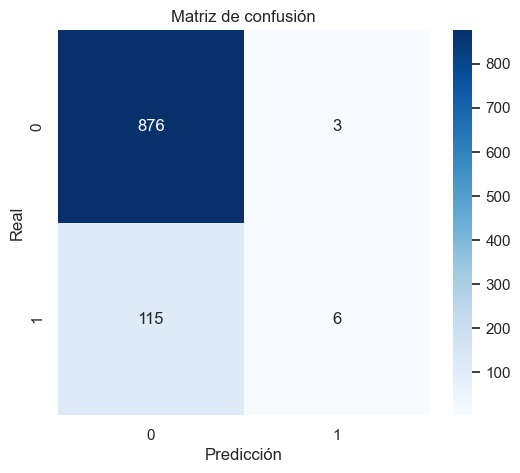

In [16]:
# Mostrar el reporte de clasificación
print(classification_report(y_test, y_pred))

# Matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues")
plt.title("Matriz de confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()